In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as pl
import wradlib
from osgeo import osr
import datetime as dt

from osgeo import gdal
from scipy.spatial import cKDTree

% matplotlib inline 


In [2]:
%%time

# Import radolan grid src
radolan_xy = wradlib.georef.get_radolan_grid(900,900)
radolan_xy = radolan_xy.reshape(-1, radolan_xy.shape[-1])
zd = wradlib.zonalstats.DataSource(radolan_xy, name='src')

CPU times: user 20.6 s, sys: 514 ms, total: 21.1 s
Wall time: 20.7 s



##  Data Input
----------------------------------
### Read an organize the data
--------------------------------



In [3]:
# new cutted gpm data path
gpm_file = '/automount/ags/velibor/gpmdata/ipol_test/2A-CS-radolan.GPM.DPR.V7-20170308.20141007-S023418-E023728.003445.V05A.HDF5'
#gpm_file = '/automount/ags/velibor/gpmdata/ipol_test/2A-CS-radolan.GPM.DPR.V7-20170308.20140510-S220856-E221212.001124.V05A.HDF5'

# define the RADOLAN RY data path
#radolan_ry_file = '/automount/ags/velibor/gpmdata/ipol_test/raa01-ry_10000-1410070235-dwd---bin'
#radolan_ry_file = '/automount/ags/velibor/gpmdata/ipol_test/raa01-ry_10000-1405102210-dwd---bin'

# 5 min later
radolan_ry_file = '/automount/radar/dwd/ry/2014/2014-10/2014-10-07/raa01-ry_10000-1410070235-dwd---bin'


## Interpolation Methode

In [4]:
def ipoli_radi(gr_grid, gr_data,sr_grid,radius):
    """

    Parameters
    ----------
    gr_grid ::: grid of the Ground Radar
    gr_data ::: data of the Ground Radar
    sr_grid ::: grid oft the Spaceborn Radar
    radius  ::: radius of the dpr foot prints


    Returns
    -------
    gs_grid ::: Interpolated Groundradar Data on Spaceborne Grid

    """
    import datetime as dt
    gr_ipoli_data = np.zeros((sr_grid.shape[0]))

    for i in range(sr_grid.shape[0]):

        # set x_0 and y_0
        x0, y0 = sr_grid[i,0], sr_grid[i,1] 

        # calc radius for all other points
        rr = np.sqrt((gr_grid[:,0] - x0)**2 + (gr_grid[:,1] - y0)**2)

        # check if footptint 
        if gr_data[rr < radius].size!=0:
            # if not empty calc mean
            #ToDo: wichtung fehlt!
            gr_ipoli_data[i] = np.nanmean(gr_data[rr < radius])

 
        else:
            # if empty set NAN
            gr_ipoli_data[i] = np.nan


    return gr_ipoli_data

## Remove all GPM scans not oncluded in radolan scan area
----------------------

In [5]:
def dpr_swath_contour(sr_grid):
    """

    Function for dpr swath grid contour
    
    ## sr_grid[:, 0]        # - complete left column
    ## sr_grid[-1,1:-1]     # - upper edge without left and right corner
    ## sr_grid[:, -1][::-1] # - complete right column (backward)
    ## sr_grid[0,0:-1]      # - lower edge (without right corner)
    
    Input:
    ------
    sr_grid ::: Space-borne grid x,y
    
    Output:
    -------
    trg ::: Contour of the space-borne grid
    
    """
    
    trg = np.r_[sr_grid[:, 0], sr_grid[-1, 1:-1], sr_grid[:, -1][::-1], sr_grid[0, 0:-1][::-1]]
    
    return trg


In [6]:
def idx_sr_in_gr_area(_bingrid, _gpm_xy):
    """
    Funktion:
    ---------
    Search for SR Footprint (Index) that are located in the GR scan area 
    
    Input: 
    ------
    _bingrid ::: Binary-grid of the GR scan area
        
    _gpm_xy ::: GPM footptint coordinates
    
    Output:
    -------
    
    _gpm_xy_outer_idx ::: index of all footprints not included in radolan scan area
    _gpm_xy_inner_idx ::: idex of all footprints included in radolan area but
                           not scanned by ground radars 
    
    """
    _gpm_xy = _gpm_xy.copy()
    # Bestimmen von Eckpunkten bei RADOLAN RY GRID!
    # HARDCODED: but ok for regula RADOLAN Produkts
    xmin, xmax = -523.4621669218559, 375.5378330781441
    ymin, ymax = -4658.644724265572, -3759.644724265572
    
    # Radolangitter um 1 gridpoit zu allen seiten erweitern
    _xex, _yex = np.arange(xmin-1, xmax+2, 1), np.arange(ymin-1, ymax+2, 1)
    _xxx, _yyy = np.meshgrid(_xex,_yex)
    
    # Bin grid bestimmen
    _bingrid = _bingrid.copy()
    _bingrid[_bingrid >= 0]=1
    _bingrid[_bingrid < 0]=0
    
    # Gittererweiterungen zusammenstellen
    ## rn_tb ::: bin gird top and bottom
    ## rn_lr ::: bin gird left and right
    rn_tb = np.zeros(900)
    rn_lr = np.zeros(902)
    
    # Griderweiterungen einsetzen
    # erst oben und unten
    rn1 = np.c_[rn_tb, _bingrid, rn_tb]
    # dann rechts
    rn2 = np.vstack((rn1, rn_lr))
    # dann rechts
    rn3 = np.vstack((rn_lr,rn2))
    
    from skimage import measure
    # Contouren des Bin-grids erstellen
    contours = measure.find_contours(rn3, 0, positive_orientation='high',
                                     fully_connected='high' )
    print(len(contours), ' detected Polygons')
    #print("---------------------")
    #for j in range(len(contours)):
    #    print(len(contours[j]))
    #print("---------------------")

    # bestiimung der Listen für Polygon Points
    _xx = []
    _yy = []

    # suche nach dem größten Polygon... dieser sollte der RADOLAN UMRISS sein
    for i in range(len(contours)):
        # Polygone mit 3 oder weniger points ergeben keine nutzbare Fläche
        if len(_xxx[contours[i][:,0].astype(int),contours[i][:,1].astype(int)]) <= 3:
            print('not relevant polygon removed')
        else:   
            # PolygonPoints bestimmen (RADOLAN RAND POINTS)
            _xx.append(_xxx[contours[i][:,0].astype(int),contours[i][:,1].astype(int)])
            _yy.append(_yyy[contours[i][:,0].astype(int),contours[i][:,1].astype(int)])
            
    # sortiern nach der länge, das letzt element ist das größte und sollte somit der Radolarand sein
    _xx.sort(key=len)
    _yy.sort(key=len)

    # Outter polygon erstellen
    _xy = np.vstack((_xx[-1].ravel(), _yy[-1].ravel())).transpose()    
    
    # Suche nach den GPM footprints im Scanngebiet von RADOLAN mit ZONALSTATS
    zdpoly = wradlib.zonalstats.ZonalDataPoly(_gpm_xy, [_xy])
    _gpm_xy_outer_idx = zdpoly.get_source_index(0)
    
    # Array for inner Polygons
    _gpm_xy_inner_idx = np.array([])
    
    # Entferne Inner Polygons
    # Auch nur wenn es weitere Polygone gibt 
    if len(_xx)>1:

        for inner_poly_index in range(len(_xx)-1):

            print ('Polygon size: ', len(_xx[inner_poly_index].ravel()))

            _xy_inner = np.vstack((_xx[inner_poly_index].ravel(),
                                  _yy[inner_poly_index].ravel())).transpose()

            _zdpoly = wradlib.zonalstats.ZonalDataPoly(_gpm_xy, [_xy_inner])

            _inner_idx = _zdpoly.get_source_index(0)

            _gpm_xy_inner_idx = np.append(_gpm_xy_inner_idx, _inner_idx)


            if _gpm_xy_inner_idx.size==0:
                print ('inner polygons do not match with SR grid')

            else:
                print('match idx with inner polygon: ', _gpm_xy_inner_idx.shape)
                    

    
    _idx_r = ~np.isin(_gpm_xy_outer_idx, _gpm_xy_inner_idx)
    
    return _gpm_xy_outer_idx[_idx_r]
        

In [7]:
def dpr_antenna_weighting(r):
    """
    Funktion: explained in 
    Watters, D., A. Battaglia, K. Mroz, and F. Tridon, 0: 
    Validation of the GPM Version-5 Surface Rainfall 
    Products over Great Britain and Ireland. 
    J. Hydrometeor., 0, https://doi.org/10.1175/JHM-D-18-0051.1
    
    and
    
    Mroz, K., A. Battaglia, T. J. Lang, D. J. Cecil, 
    S. Tanelli, and F. Tridon, 2017:  Hail-detection
    algorithm for the GPM Core Observatory satellite sensors.
    Journal of Applied Meteorology and Climatology,56 (7), 1939–1957
    
    Input:
    ------
    r ::: Distance to the center point of the footprint
    
    Output:
    -------
    omega ::: Weighting for the point with the distance
    
    """
    
    omega = np.exp(-(r/2.5)**2. * np.log10(4.))
    
    return omega

In [8]:
# calculation duration start time
t1 = dt.datetime.now()

## Read GPM Data
---------------------------------------


In [9]:
%%time
# read gpm file with importatnt parameters
gpmdpr = h5py.File(gpm_file, 'r')

# Scan swath
sc = 'NS'

# GPM navigation and time
gpm_lat = np.array(gpmdpr[sc]['Latitude'])
gpm_lon = np.array(gpmdpr[sc]['Longitude'])

# Precipitation data in RADOLAN region
# Posible products:
# precipRateAve24
# precipRateESurface
# precipRateNearSurface
dpr_pns = np.array(gpmdpr[sc]['SLV']['precipRateAve24'])
dpr_pns[dpr_pns ==-9999.9]= np.nan

CPU times: user 4.93 ms, sys: 31 µs, total: 4.96 ms
Wall time: 6.53 ms


## GPM coordinates projection
----------------------------------------------

In [10]:
%%time

# Determine projection
proj_stereo = wradlib.georef.create_osr("dwd-radolan")
proj_wgs = osr.SpatialReference()
proj_wgs.ImportFromEPSG(4326)

# GPM coordinate projection
gpm_x, gpm_y = wradlib.georef.reproject(gpm_lon, gpm_lat,
                                        projection_target=proj_stereo,
                                        projection_source=proj_wgs)

CPU times: user 65.8 ms, sys: 0 ns, total: 65.8 ms
Wall time: 66 ms


In [12]:
%%time

# read radolan ry file data and attributes
rwdata, rwattrs = wradlib.io.read_radolan_composite(radolan_ry_file)

radolan_grid_xy = wradlib.georef.get_radolan_grid(900,900)
x = radolan_grid_xy[:,:,0]
y = radolan_grid_xy[:,:,1]
rwdata = np.ma.masked_equal(rwdata, -9999) *12 # Um auf mm/h zu kommen, beim Einlesen sind es mm/5min

# copy data for binary grid
bingrid = rwdata.copy()

CPU times: user 41.7 ms, sys: 16.1 ms, total: 57.8 ms
Wall time: 58.4 ms


## Read RADOLAN Data
-----------------

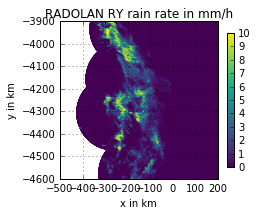

In [12]:
fig = pl.figure(figsize=(12,8))
ax = fig.add_subplot(131, aspect="equal")
pl.scatter(x, y, c=rwdata, cmap=pl.cm.viridis, vmin=0, vmax=10, edgecolor="None")
pl.title("RADOLAN RY rain rate in mm/h")
pl.colorbar(shrink=0.3)
pl.xlabel("x in km")
pl.ylabel("y in km")
pl.xlim(-500, 200)
pl.ylim(-4600, -3900)
pl.grid()

## Remove all GPM footprint that are not in scan area of radolan
-------------------

In [13]:
%%time

# GPM Koordinaten ravel
gpm_xy = np.vstack((gpm_x.ravel(), gpm_y.ravel())).transpose()

# index for GPM footprints in scan area
oi_idx = idx_sr_in_gr_area(bingrid, gpm_xy)

# entferne alle Indizes auserhalb des äußeren Polygons
gpm_xy = gpm_xy[oi_idx]
gpm_pns = dpr_pns.ravel()[oi_idx]

(1, ' detected Polygons')
CPU times: user 644 ms, sys: 85.4 ms, total: 730 ms
Wall time: 643 ms


## Remove all RADOLAN Points not included in GPM DPR swath
-------------------------------

In [14]:
%%time
# Contour from ORIGINAL DPR Overpass
dpr_contour_x = dpr_swath_contour(gpm_x)
dpr_contour_y = dpr_swath_contour(gpm_y)
print(dpr_contour_x.shape)

(641,)
CPU times: user 269 µs, sys: 10 µs, total: 279 µs
Wall time: 259 µs


In [15]:
%%time
# create dpr polygon of dpr xy contours 
dpr_xy_poly = np.vstack((dpr_contour_x.ravel(), dpr_contour_y.ravel())).transpose()

CPU times: user 63 µs, sys: 0 ns, total: 63 µs
Wall time: 67.9 µs


In [16]:
%%time
#load regular radolan grid and overlie with dpr contours
zd_poly_radolan = wradlib.zonalstats.ZonalDataPoint(zd, [dpr_xy_poly], buf=2.5)

# get radolan index in dpr swath
ry_idx = zd_poly_radolan.get_source_index(0)

# get radolan index in dpr swath AND in binary grid
rwtest = ~np.ma.masked_less(rwdata, 0).mask

radolan_idx = np.flatnonzero(rwtest.ravel())

ry_idx2 = np.intersect1d(ry_idx, radolan_idx, assume_unique=True)

CPU times: user 9.64 s, sys: 145 ms, total: 9.79 s
Wall time: 9.66 s


In [17]:
# Radolan xy array
xy_radolan = np.vstack((x.ravel(), y.ravel())).transpose()

In [18]:
%%time
# Extract all affected RADOLAN grid points
rwdata_cut = rwdata.ravel()[ry_idx2]
x_cut = xy_radolan[...,0].ravel()[ry_idx2].copy()
y_cut = xy_radolan[...,1].ravel()[ry_idx2].copy()

CPU times: user 5.76 ms, sys: 61 µs, total: 5.82 ms
Wall time: 4.67 ms


## Interpolation of radolan to dpr 
-------------------------

In [19]:
%%time
# Compare all cutted radolan x and y 
xy_cut = np.vstack((x_cut.ravel(), y_cut.ravel())).transpose()

#Dpr footprint radius 
dpr_footprint = 2.6 #radius in km

CPU times: user 1.41 ms, sys: 0 ns, total: 1.41 ms
Wall time: 1.19 ms


In [20]:
def ipoli_radi_w(xy_cut, gpm_xy,rwdata_cut, dpr_footprint, k=25):
    """
    ...
    """
    # cKDTree radolan
    tree = cKDTree(xy_cut, balanced_tree=False)

    # cKDTree gpm dpr
    tree_gpm = cKDTree(gpm_xy, balanced_tree=True)

    dists, ix = tree.query(gpm_xy, k=k, n_jobs=-1) # k maximal possible ry pixel in dpr footprint
    ix2 = tree.query_ball_point(gpm_xy, dpr_footprint)

    ry_pns_w = []

    for i in range(ix.shape[0]):
        #i is all points in one dpr footprint
        #distancen for all i
        index = np.isin(ix[i,:],ix2[i] )
        res1 = np.nansum( dpr_antenna_weighting(dists[i,:][index]) * rwdata_cut.ravel()[ix[i,:][index]])
        res2 = np.nansum(dpr_antenna_weighting(dists[i,:][index]))

        ry_pns_w.append(res1/res2)


    return np.array(ry_pns_w)   

In [21]:
xy_cut.shape, gpm_xy.shape, rwdata_cut.shape

((218893, 2), (7884, 2), (218893,))

In [22]:
%%time
ry_pns_w = ipoli_radi_w(xy_cut, gpm_xy, rwdata_cut, dpr_footprint, k=25)

CPU times: user 3.84 s, sys: 2.49 ms, total: 3.85 s
Wall time: 3.81 s


In [23]:
print('-----------------')
print(dt.datetime.now() - t1)
print('-----------------')


-----------------
0:00:30.421228
-----------------


## Some Comparison of 2d Data
--------------------------------------------

-----------------
('Correlation: ', 0.8516541931504417)
('Correlation with zeros: ', 0.9233295890472111)
-----------------
CPU times: user 665 ms, sys: 411 ms, total: 1.08 s
Wall time: 551 ms


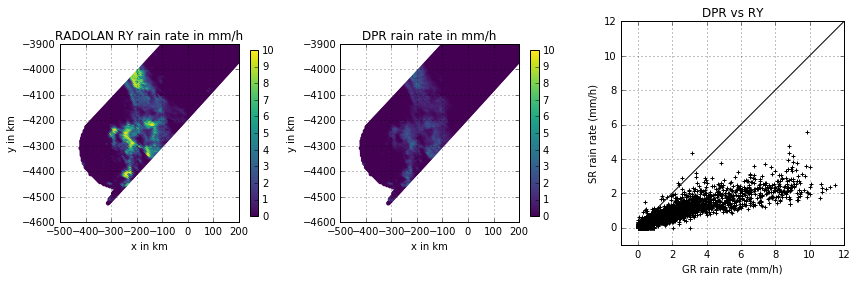

In [24]:
%%time

fig = pl.figure(figsize=(12,8))
ax = fig.add_subplot(131, aspect="equal")
pl.scatter(gpm_xy[..., 0], gpm_xy[...,1], c=ry_pns_w, cmap=pl.cm.viridis, vmin=0, vmax=10, edgecolor="None")
pl.title("RADOLAN RY rain rate in mm/h")
pl.colorbar(shrink=0.3)
pl.xlabel("x in km")
pl.ylabel("y in km")
pl.xlim(-500, 200)
pl.ylim(-4600, -3900)
pl.grid()

ax = fig.add_subplot(132, aspect="equal")
pl.scatter(gpm_xy[..., 0], gpm_xy[...,1], c=gpm_pns, cmap=pl.cm.viridis, vmin=0, vmax=10, edgecolor="None")
pl.title("DPR rain rate in mm/h")
pl.colorbar(shrink=0.3)
pl.xlabel("x in km")
pl.ylabel("y in km")
pl.xlim(-500, 200)
pl.ylim(-4600, -3900)
pl.grid()

ax = fig.add_subplot(133, aspect="equal")
pl.scatter(ry_pns_w, gpm_pns, marker="+", c="black")
pl.plot([0,60],[0,60], linestyle="solid", color="black")
pl.xlim(-1,12)
pl.ylim(-1,12)
pl.xlabel("GR rain rate (mm/h)")
pl.ylabel("SR rain rate (mm/h)")
pl.title("DPR vs RY")
pl.grid()

pl.tight_layout()


pos = (ry_pns_w > 0.) & (gpm_pns > 0.)
print('-----------------')
print('Correlation: ',np.corrcoef(ry_pns_w[pos], gpm_pns[pos])[0][1])
print('Correlation with zeros: ',np.corrcoef(ry_pns_w, gpm_pns)[0][1])
print('-----------------')

## Explanation of antenna gain weighting
-----------------------------------------------------------

$$\omega_i = exp[-(r_i/2.5)^2 ln(4)]$$

$i$ : corresponds to each 1 km RADOLAN pixel in DPR Footprint

$r_i$ : distance in kilometers between Radolan Pixel and DPR center point

##### The Weighted GR estimates in DPR footprint:

$$\bar{GR} = \frac{ \sum\nolimits_{i=1}^N \omega_i GR_i }{ \sum\nolimits_{i=1}^N \omega_i} $$

> Funktion: eplained in 
>    Watters, D., A. Battaglia, K. Mroz, and F. Tridon, 0: 
>    Validation of the GPM Version-5 Surface Rainfall 
>    Products over Great Britain and Ireland. 
>    J. Hydrometeor., 0, https://doi.org/10.1175/JHM-D-18-0051.1


> Mroz, K., A. Battaglia, T.J. Lang, D.J. Cecil, S. Tanelli, and F. Tridon, 2017: Hail-Detection Algorithm for the GPM Core Observatory Satellite Sensors. J. Appl. Meteor. Climatol., 56, 1939–1957, https://doi.org/10.1175/JAMC-D-16-0368.1

In [25]:
# Calculating some footprint geometries
x = y = np.arange(-3,3,0.01)
xx, yy = np.meshgrid(x,y)
rr = np.sqrt(xx**2 +yy**2)

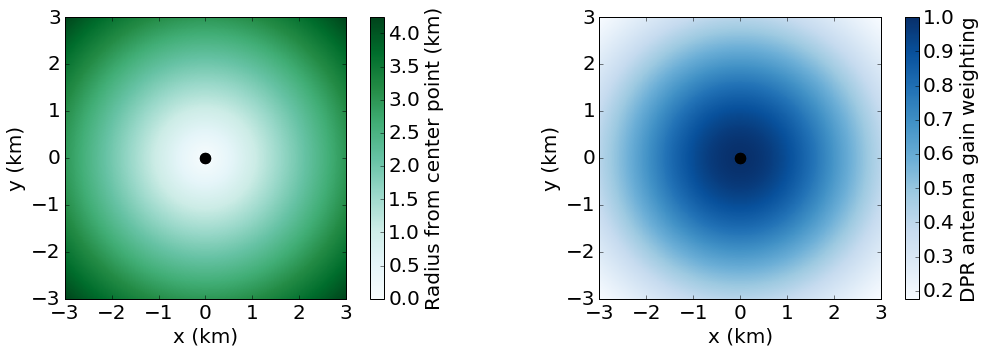

In [26]:
# plot footprint distance and weighting
pl.figure(figsize=(15,5))
ff=20; cc=1
pl.subplot(1,2,1, aspect='equal')
pl.pcolormesh(xx,yy,rr, cmap='BuGn')
cb = pl.colorbar(shrink=cc)
cb.set_label("Radius from center point (km)", fontsize=20)
cb.ax.tick_params(labelsize=20)
pl.scatter([0,0],[0,0], s=70, lw=3, color='black')
#pl.title('Radius from centerpoint (km)', fontsize=ff)
pl.xlabel('x (km)', fontsize=ff);pl.ylabel('y (km)', fontsize=ff)
pl.xlim(-3,3),pl.ylim(-3,3)
pl.xticks(fontsize=ff); pl.yticks(fontsize=ff)


pl.subplot(1,2,2, aspect='equal')
pl.pcolormesh(xx,yy,dpr_antenna_weighting(rr), cmap='Blues')
cb = pl.colorbar(shrink=cc)
cb.set_label("DPR antenna gain weighting", fontsize=20)
cb.ax.tick_params(labelsize=20)
pl.scatter([0,0],[0,0], s=70, lw=3, color='black')
pl.xlim(-3,3),pl.ylim(-3,3)
#pl.title('DPR Antenna gain weighting', fontsize=ff)
pl.xlabel('x (km)', fontsize=ff);pl.ylabel('y (km)', fontsize=ff)
pl.xticks(fontsize=ff); pl.yticks(fontsize=ff)

pl.tight_layout()